In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from models import LANGCAD 
from main import load_caption
import open_clip 

def collate_fn(batch):
    images = []
    pos_texts = []
    neg_texts = []
    
    for item in batch:
        image, pos_text, neg_text = item
        images.append(image)
        pos_texts.append(pos_text)
        neg_texts.extend(neg_text)
    
    # Stack images into a single tensor
    images = torch.stack(images, dim=0)
    
    return images, pos_texts, neg_texts 

os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/LANGCAD.yaml'
cfg = parser(True,default_setting, model_setting)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        )
device = 'cuda'

caption_dict = load_caption(
        datadir     = cfg.DATASET.datadir,
        dataset     = cfg.DATASET.dataset_name,
        class_names = cfg.DATASET.class_names
    )

loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        caption_dict  = caption_dict, 
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        collate_fn  = collate_fn,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 32,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    

/usr/local/lib/python3.8/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



 Experiment Name : SOTA + small memory bank: 196



In [2]:
model.pool.load_pool('/Volume/VAD/LifeLongerAD/results/LANGCAD/MVTecAD/contrastive with only hard negative + lr 0.005 + no margin/seed_0/last_pool.pth')
prompts = model.create_prompts()

Load done


In [2]:
from tqdm import tqdm 
model.anomaly_scorer.fit(np.expand_dims(np.array(model.pool.knowledge),0))

index_store = [] 
for cln, loaders in tqdm(loader_dict.items()):
    testloader = loaders['test']
    
    prompts, model, testloader = accelerator.prepare(prompts, model, testloader)
    
    for idx, (images, labels, gts) in enumerate(testloader):
        with torch.no_grad():
            features = model.embed_img(images).detach().cpu().numpy()
            query_features = np.mean(features,axis=(0,1))
            prompts = model.pool.retrieve_prompts(prompts, query_features).to(device)
            
        break 
    break  

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [17]:
index_store = np.concatenate(index_store)

In [22]:
len(model.pool.knowledge)

73301

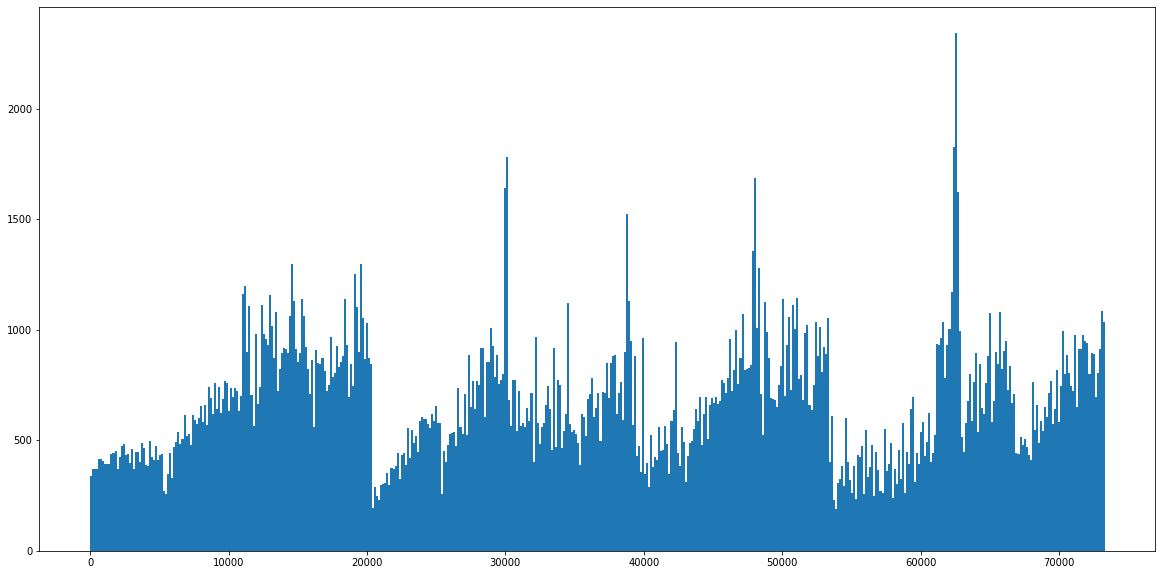

In [32]:
plt.figure(figsize=(20,10))
plt.hist(index_store[:,0],bins=500)
plt.show()

In [28]:
np.unique(index_store).shape

(70636,)